# Text Classification  SKB Graph on Ohsumed via POS
* TC-SKB-GRAPH-Ohsumed
---

In [514]:
import nltk
import numpy as np
import re
import glob
import os
import tqdm
import torch
import sys
import json
import spacy
import pandas as pd
import seaborn as sns
from collections import OrderedDict
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

dataset = "ohsumed"

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/adaptsystemlab2019/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/adaptsystemlab2019/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/adaptsystemlab2019/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


device(type='cuda')

In [498]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"patients ", "", string)
    return string.strip().lower()

In [499]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
def lemmatization(sentence):
    tokens = word_tokenize(sentence)
    tagged_sent = pos_tag(tokens)
    wnl = WordNetLemmatizer()
    lemmas_sent = []
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        lemmas_sent.append((wnl.lemmatize(tag[0], pos = wordnet_pos),wordnet_pos))
    return lemmas_sent

def getPos(sentence):
    tokens = word_tokenize(sentence)
    tagged_sent = pos_tag(tokens)
    sent = []
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        sent.append((tag[0], wordnet_pos))
    return sent

In [500]:
def countMinMaxAver(lines):
    min_len = 10000
    aver_len = 0
    max_len = 0
    for temp in lines:
        aver_len = aver_len + len(temp)
        if len(temp) < min_len:
            min_len = len(temp)
        if len(temp) > max_len:
            max_len = len(temp)
    aver_len = 1.0 * aver_len / len(lines)
    print('min_len : ' + str(min_len))
    print('max_len : ' + str(max_len))
    print('average_len : ' + str(aver_len))

## remove stop words

In [501]:
def _getTextFile(langual):
    file_list = glob.glob(f'../data/stopwords/stopwords/*_{langual}.txt')
    files = ",".join(file_list)
    return files
def cleanText(english_txt):
    try:
        word_tokens = english_txt.split()
        filtered_word = [w for w in word_tokens if w not in stop_words and not w.isdigit()]
        filtered_word = [w + " " for w in filtered_word]
        return "".join(filtered_word)
    except:
        return np.nan
def cleanNonEnglish(txt):
    txt = clean_str(txt)
    txt = re.sub(r'\W+', ' ', txt)
    txt = txt.lower()
    txt = txt.replace("[^a-zA-Z]", " ")
    word_tokens = txt.split()
    filtered_word = [w for w in word_tokens if all(ord(c) < 128 for c in w)]
    filtered_word = [w + " " for w in filtered_word]
    return "".join(filtered_word)

In [502]:
stop_words = set()
for file in _getTextFile("en").split(","):
    for word in open(file):
        stop_words.add(word.strip())

In [503]:
doc_content_list = []
f = open('../data/corpus/' + dataset + '.txt', 'rb')
for line in f.readlines():
    doc_content_list.append(line.strip().decode('latin1'))
f.close()

In [504]:
countMinMaxAver([item.split() for item in doc_content_list])

min_len : 28
max_len : 596
average_len : 186.03851351351352


In [505]:
doc_content_list = [cleanText(cleanNonEnglish(sentence).strip()).strip() for sentence in doc_content_list]

In [506]:
#doc_content_list = [" ".join([lemmatization(word) for word in sentence.split()]) for sentence in tqdm.tqdm(doc_content_list)]

In [507]:
countMinMaxAver([item.split() for item in doc_content_list])

min_len : 14
max_len : 324
average_len : 97.195


In [508]:
len(doc_content_list)

7400

In [416]:
np.save("../data/corpus/" + dataset+".clean", doc_content_list)

### Get sememes for OOV
Get the DictSKB and own SKB-DA

In [509]:
doc_content_list: list = np.load("../data/corpus/" + dataset+".clean.npy", allow_pickle=True).tolist()

In [510]:
ohsumed_tagme: dict = np.load("../data/corpus/ohsumed.tagme.npy", allow_pickle=True).tolist()

In [487]:
#len(ohsumed_tagme) == len(doc_content_list)
#lack_index = set([n for n in range(0,7400)]) - set([int(n) for n in ohsumed_tagme.keys()])
#lack_index = next(iter(lack_index))
#ohsumed_tagme[str(lack_index)] = (["non"],["non"])
#ohsumed_tagme = OrderedDict(sorted(ohsumed_tagme.items()))
#list(ohsumed_tagme.items())[-1]

Replace the entity to title on docment

In [223]:
def replaceEntity2titleOnDoc(docs,tagme_dict):
    replace_entity2title_dict = {}
    for index, doc in enumerate(docs):
        index_str = str(index)
        if index_str in tagme_dict.keys():
            tagme_dict[index_str][0]
            tagme_dict[index_str][1]
            for spot_index, spot in enumerate(tagme_dict[index_str][0]):
                doc = doc.replace(spot, tagme_dict[index_str][1][spot_index].replace(" ", "_"))
            replace_entity2title_dict[index] = doc
        else:
            replace_entity2title_dict[index] = doc
    return replace_entity2title_dict

In [224]:
#doc_content_list = replaceEntity2titleOnDoc(doc_content_list,ohsumed_tagme)

In [233]:
#doc_content_list[999]

In [234]:
#ohsumed_tagme["999"]

In [419]:
dictskb = np.load("../sememe_dataset/DictSKB_dict.npy", allow_pickle=True).tolist()
dictskb_cdv = np.load("../sememe_dataset/DictSKB_sememes.npy", allow_pickle=True).tolist()
#skb_ad = np.load("../sememe_dataset/skb_ad_dict.npy", allow_pickle=True).tolist()
networkskb = np.load("../sememe_dataset/sememe_network_dict_en_wordnet_5000.npy", allow_pickle=True).tolist()
networkskb_cdv = np.load("../sememe_dataset/sememe_network_cdv_en_wordnet_5000.npy", allow_pickle=True).tolist()

In [420]:
def skbUniform(skb):
    sememe_network_wordnet = {}
    for k,v in skb.items():
        index = k.split(".")[-1]
        pos = k.split(".")[-2]
        word = "".join(k.split(".")[:-2])
        if word not in sememe_network_wordnet.keys():
            sememe_network_wordnet[word] = []
        sememe_network_wordnet[word].append((pos,v))
    return sememe_network_wordnet

In [421]:
networkskb = skbUniform(networkskb)

In [422]:
sum([len(sences) for sences in networkskb.values()])

171580

In [423]:
# preprocessing for skb_ad_dict
# def onceSence(skb):
#     skb_once_sence = {}
#     for word, sences_list in skb.items():
#         if len(sences_list) > 1:
#             sences_once = []
#             pos_list = []
#             for (pos, sememe_set) in sences_list:
#                 if not pos.islower():
#                     if pos not in pos_list:
#                         pos = get_wordnet_pos(pos)
#                         pos_list.append(pos)
#                         #sences_once.append((pos,sememe_set))
#                         #print(get_wordnet_pos(pos))
#                 if pos.islower():
#                     #sences_once.append((pos,sememe_set))
#                     pos_list.append(pos)
#             skb_once_sence[word] = sences_once
#         else:
#             skb_once_sence[word] = [(get_wordnet_pos(pos), sences) for (pos, sences) in sence_list]       
#     return skb_once_sence

In [424]:
#skb_ad_dict = onceSence(skb_ad_dict)

In [425]:
def tagmeProcess(tagme_json):
    tagme_dict = {}
    for items in tqdm.tqdm(tagme_json):
        if not items:
            continue 
        i, entityList = items.split("\t")
        if entityList == "null" or len(entityList) == 0:
            continue
        entityList = json.loads(entityList)
        entities_spot = [d['spot'] for d in entityList if 'title' in d and float(d['rho']) > 0.1]
        entities_title = [d['title'] for d in entityList if 'title' in d and float(d['rho']) > 0.1]
        entities = (entities_spot,entities_title)
        if i not in tagme_dict.keys():
            tagme_dict[i] = []
        tagme_dict[i] = entities
    return tagme_dict

In [426]:
ohsumed_tagme = tagmeProcess(ohsumed_tagme)

100%|█████████████████████████████████████| 7400/7400 [00:00<00:00, 9443.12it/s]


In [427]:
# lemmatization(doc_content_list[0])

In [428]:
def wordFreq(docs):
    word_freq = {}
    for doc in docs:
        for word in doc.split():
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    return word_freq

In [459]:
def evaluationFrequncy(docs,save_name):
    word_freq = wordFreq(docs)
    print("#all word size: ", len(word_freq))
    word_freq_sorted = sorted(word_freq.items(), key = lambda kv:(kv[1], kv[0]))
    print("#frequncy mean: ", np.mean(list(word_freq.values())))
    print("#frequncy standard deviation: ", np.std(list(word_freq.values())))
    print("#frequncy std/mean: ", np.std(list(word_freq.values()))/np.mean(list(word_freq.values())))
    axes = sns.scatterplot(data=list(word_freq.values()))
    axes.figure.set_size_inches(18,6)
    fig = axes.get_figure()
    fig.savefig("../data/images/"+save_name+".png", dpi = 400)
    return word_freq, word_freq_sorted

## Replace Word to Sememe for Variance

word to sememes dictionary for low frequency word

In [481]:
def Word2wordsDict(word_freq_dict,skb_dict):
    replace_word2words_dict = {}
    word_freq_mean = np.mean(list(word_freq.values()))+(np.std(list(word_freq.values()))/np.mean(list(word_freq.values())))
    for word, freq in tqdm.tqdm(word_freq_dict.items()):
        if freq < word_freq_mean:
            '''word : sememe '''
            if word in skb_dict.keys():
                replace_word2words_dict[word] = skb_dict[word]
            else:
                replace_word2words_dict[word] = word
        else:
            replace_word2words_dict[word] = word
    return replace_word2words_dict

In [493]:
def replaceDocsList(skb_dict,documents_list,word2words):
    documents_list_reoov = []
    for document in tqdm.tqdm(documents_list):
        document = getPos(document)
        document_list_reoov = []
        for (word, doc_pos) in document:
            if word in word2words.keys():
                if type(word2words[word]) == list:
                    if len(word2words[word]) == 1:
                        document_list_reoov = document_list_reoov + list(word2words[word][0][1])
                        continue
                    #elif len(word2words[word]) > 1:
                        #for (skb_pos, sememe_set)  in word2words[word]:
                            #if doc_pos == skb_pos:
                                #document_list_reoov = document_list_reoov + list(sememe_set)
                                #break
                    #else:
                        #for (skb_pos, sememe_set)  in word2words[word]:
                            #if skb_pos == "n":
                                #document_list_reoov = document_list_reoov + list(sememe_set)
                                #break
                else:
                    document_list_reoov.append(word)
            else:
                print(word)
                break
        documents_list_reoov.append(" ".join(document_list_reoov))
    return documents_list_reoov

In [494]:
def boostFrequency(word_freq_dict, skb_dict, documents_list):
    word2words = Word2wordsDict(word_freq_dict, skb_dict)
    replacement_rate = len([item for item in word2words.values() if type(item) == list])
    print("replacement rate: ", replacement_rate,"/",len(word2words))
    countMinMaxAver(word2words.values())
    doc_content_list_clean = replaceDocsList(networkskb,doc_content_list,word2words)
    return doc_content_list_clean

#all word size:  31963
#frequncy mean:  22.502362106185277
#frequncy standard deviation:  96.59746181770852
#frequncy std/mean:  4.29276985953206


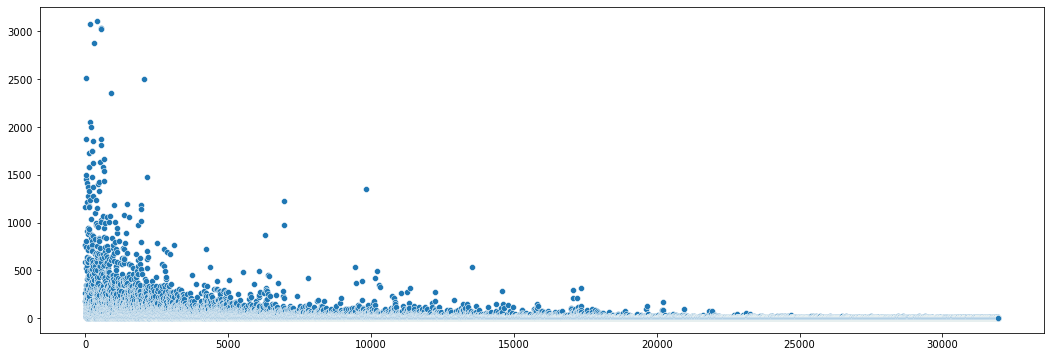

In [495]:
word_freq, word_freq_sorted = evaluationFrequncy(doc_content_list,"raw_ohsumed")

In [496]:
first_doc_content_list_clean = boostFrequency(word_freq,networkskb,doc_content_list)

100%|████████████████████████████████| 31963/31963 [00:00<00:00, 1584888.39it/s]


replacement rate:  9208 / 31963
min_len : 1
max_len : 41
average_len : 7.097925726621406


100%|██████████████████████████████████████| 7400/7400 [00:26<00:00, 281.31it/s]


#all word size:  25397
#frequncy mean:  32.84179233767768
#frequncy standard deviation:  127.36215578998437
#frequncy std/mean:  3.8780513097596194


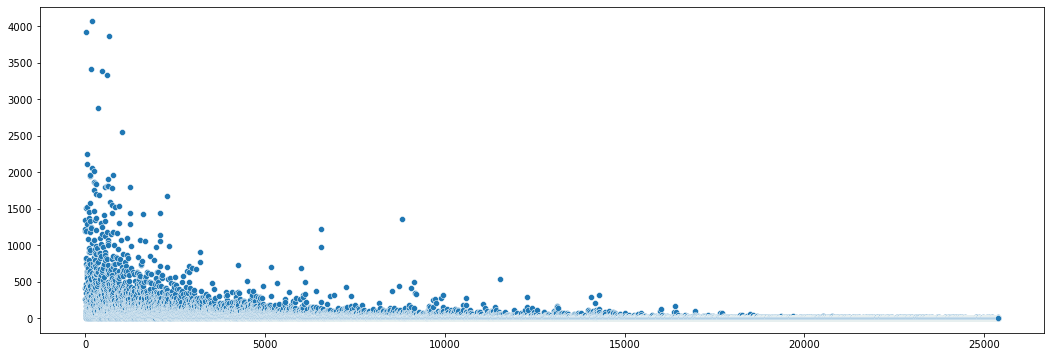

In [492]:
first_word_freq, first_word_freq_sorted = evaluationFrequncy(first_doc_content_list_clean,"first_ohsumed")

In [476]:
np.save("../data/clean/first_docs_clean",first_doc_content_list_clean)

### Second 

100%|████████████████████████████████| 26084/26084 [00:00<00:00, 1857930.30it/s]


replacement rate:  1394 / 26084
min_len : 1
max_len : 30
average_len : 8.52231252875326


100%|██████████████████████████████████████| 7400/7400 [00:26<00:00, 284.43it/s]


#all word size:  24679
#frequncy mean:  28.393127760444102
#frequncy standard deviation:  110.61956660337256
#frequncy std/mean:  3.8959979167030077


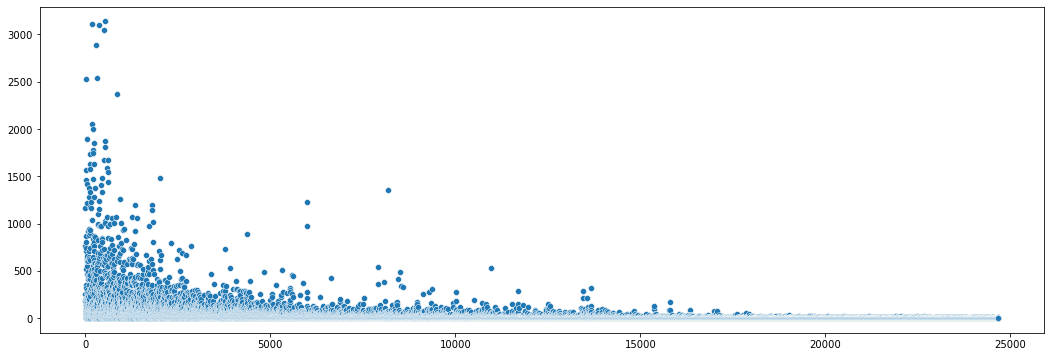

In [480]:
second_doc_content_list_clean = boostFrequency(first_word_freq,networkskb,first_doc_content_list_clean)
second_word_freq, second_word_freq_sorted = evaluationFrequncy(second_doc_content_list_clean,"second_ohsumed")
np.save("../data/clean/second_docs_clean",second_doc_content_list_clean)